# ABIDE subtype analysis
Follow the approach outlined in [Pierre's prevent_ad script](https://github.com/SIMEXP/Projects/blob/master/preventad/preventad_xp_2015_01_28b.m).

Building on this, I automatically cycle through all of the possible analyses so I can perform cross network and subtype FDR correction on the parameter estimates of the diagnosis variable.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_mask(mask_path):
    """
    Get the mask
    """
    m_img = nib.load(mask_path)
    mask = m_img.get_data()
    mask = mask!=0

    return mask, m_img

In [4]:
def prep_pheno(pheno_path, data_path, map_type, template):
    """
    Remove entries with duplicates or no imaging files
    """
    pheno = pd.read_csv(pheno_path)
    drop_id = list()
    path_list = list()
    pheno = pd.read_csv(pheno_path)
    for index, row in pheno.iterrows():
        s_id = row['SUB_ID']
        s_path = glob.glob(os.path.join(data_path, map_type, template.format(s_id, map_type)))
        if s_path:
            path_list.append(s_path[0])
        else:
            drop_id.append(index)
            continue
    clean_pheno = pheno.drop(drop_id)
    
    return clean_pheno, path_list

In [5]:
def get_files(paths, mask, net_id):
    """
    Get files from a list of paths and store the masked
    time series in an array and demean it
    """
    n_vox = np.sum(mask)
    n_files = len(path_list)
    # Prepare the storage matrix
    net_mat = np.zeros((n_vox, n_files))
    # Go through the files
    print('Grabbing network {}'.format(net_id+1))
    for index, s_path in enumerate(path_list):
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_mat[..., index] = f_net
    # Don't demean anything here, just return the array
    
    return net_mat

In [6]:
def make_corr(net_mat):
    """
    Build a subject by subject correlation matrix
    from the spatial maps and use hierarchical clustering
    to find a subtype partition
    """
    # Make a correlation matrix of the subjects
    corr_sub = np.corrcoef(net_mat, rowvar=0)
    link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
    
    return (corr_sub, link_sub)

In [7]:
def make_part(link_sub, subtypes):
    """
    Partition subjects into groups based on
    hierarchical clustering linkage
    """
    part_sub = scl.hierarchy.fcluster(link_sub, subtypes, criterion='maxclust')
    
    return part_sub

In [8]:
def prep_glm(pheno, net_mat, part_sub):
    """
    Prepare a glm
    """
    n_vox = net_mat.shape[0]
    n_files = net_mat.shape[1]
    subtypes = len(np.unique(part_sub))
    # Make the average of the subtypes
    sbt_avg = np.zeros((n_vox, subtypes))
    for idx in range(subtypes):
        sub_id = np.unique(part_sub)[idx]
        # Zero mean, unit variance
        tmp_sbt_map = np.mean(net_mat[...,part_sub==sub_id],1)
        tmp_mean = np.mean(tmp_sbt_map)
        tmp_std = np.std(tmp_sbt_map)
        sbt_avg[..., idx] = (tmp_sbt_map - tmp_mean)/tmp_std
    
    # Generate the individual weights
    weights = np.zeros((n_files, subtypes))
    for s_id in range(subtypes):
        type_map = sbt_avg[:, s_id]
        weights[:, s_id] = np.array([np.corrcoef(type_map, net_mat[:,x])[0,1] for x in range(n_files)])
    
    # Generate the model matrix
    factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    
    return (weights, glm_pheno, sbt_avg)

In [9]:
def visu_net(corr_sub, link_sub, val_range=[0,1], colm=cm.coolwarm):
    """
    Show the correlation map and the hierarchical clustering
    to get an idea of the data structure
    """
    f = plt.figure(figsize=(8,10))
    ax = f.add_subplot(111)
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 0.9, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 0.9, 0.7])
    subcol = bb.visu.add_subplot_axes(ax, [0.91, 0, 0.09, 1])
    Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
    idx = Z1['leaves']
    tmp = corr_sub[idx, :]
    show_corr = tmp[:, idx]
    pc = submat.matshow(show_corr, aspect='auto',vmin=val_range[0], vmax=val_range[1], cmap=colm)
    plt.colorbar(pc, cax=subcol)
    subdend.set_xticklabels([])
    submat.set_xticklabels([])
    submat.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [10]:
def visu_weights(weights, part_sub, yrange=[0.3,1]):
    """
    Show the weights of each subtype
    """
    subtypes = len(np.unique(part_sub))
    # Show the weights by subtype
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
    for i, stp in enumerate(np.unique(part_sub)):
        ax = fig.add_subplot(gs[0,i])
        ax.set_ylim(yrange)
        ax.set_xticklabels([])
        # Take a subsample of the data, fitting the current subtype
        stp_data = weights[part_sub==stp,:]
        tmp = ax.violinplot(stp_data)
        ax.set_title('subjects subtype {}'.format(i+1))

In [11]:
def visu_covar(clean_pheno, part_sub):
    """
    Show some covariates
    """
    # Do one more run, but look at motion
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, 3, wspace=0.3)
    ages = [clean_pheno.loc[part_sub==stp]['AGE_AT_SCAN'].values for stp in np.unique(part_sub)]
    frames = [clean_pheno.loc[part_sub==stp]['frames_scrubbed '].values for stp in np.unique(part_sub)]
    motion = [clean_pheno.loc[part_sub==stp]['FD_scrubbed'].values for stp in np.unique(part_sub)]
    # Age
    ax_age = fig.add_subplot(gs[0,0])
    ax_age.set_xticklabels([])
    tmp = ax_age.violinplot(ages)
    ax_age.set_title('Age')
    # Age
    ax_frame = fig.add_subplot(gs[0,1])
    ax_frame.set_xticklabels([])
    tmp = ax_frame.violinplot(frames)
    ax_frame.set_title('Scrubbed Frames')
    # Age
    ax_motion = fig.add_subplot(gs[0,2])
    ax_motion.set_xticklabels([])
    tmp = ax_motion.violinplot(motion)
    ax_motion.set_title('Scrubbed FD')

In [12]:
def visu_subtype(subtype_map, mask_path, threshold=0.3, figsz=(10,8), colm=cm.spring):
    """
    Show the subtype maps
    """
    # Load the mask again to get the image
    mask, mask_image = get_mask(mask_path)
    # Get the subtypes out
    n_sbt = subtype_map.shape[1]
    # Prepare the figure
    fig = plt.figure(figsize=figsz)
    gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
    for s_id in range(n_sbt):
        sbt_map = subtype_map[:, s_id]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = sbt_map
        # Make a nifti image out of the volume
        nifti_vol = nib.Nifti1Image(template, affine=mask_image.get_affine(), header=mask_image.get_header())
        # Visualize the thing with nilearn
        ax = fig.add_subplot(gs[s_id,0])
        nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),axes=ax, cmap=colm, threshold=threshold)

In [13]:
def run_glm(weights, glm_pheno, subtype=0):
    """
    Run the GLM
    """
    model = sm.OLS(weights[:,subtype], glm_pheno)
    results = model.fit()
    print(results.summary())
    return results

In [14]:
# Test a little bit
scale = 12
n_subtypes = 4
template = '*_fmri_{:07d}_session_1_run1_{}.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/merged_pheno.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
map_types = ['stability_maps', 'rmap_part', 'dual_regression']
map_type = map_types[0]

In [15]:
mask, mask_img = get_mask(mask_path)
# Get nonduplicate paths
(clean_pheno, path_list) = prep_pheno(pheno_path, data_path, map_type, template)

In [16]:
# Build the looper
n_vox = np.sum(mask)
# Prepare the storage variables
pval_store = np.zeros((scale, n_subtypes))
subtype_store = np.zeros((scale, n_vox, n_subtypes))
model_store = [[]] * scale
# Iterate through the networks
for net_id in np.arange(scale):
    print('Running Network {} now'.format(net_id+1))
    # Get the files and demean them across subjects
    tmp_mat = get_files(path_list, mask, net_id)
    grand_average = np.reshape(np.mean(tmp_mat, 1), (tmp_mat.shape[0], 1))
    net_mat = tmp_mat - grand_average
    # Build the correlation matrix
    (corr_sub, link_sub) = make_corr(net_mat)
    # Decide how many subtypes we want
    part_sub = make_part(link_sub, n_subtypes)
    # Get the weights and the GLM model matrix
    (weights, glm_pheno, subtype_map) = prep_glm(clean_pheno, net_mat, part_sub)
    # Store the subtype maps
    subtype_store[net_id, ...] = subtype_map
    # Iterate over the subtypes
    for sbt_id in np.arange(n_subtypes):
        print('    running subtype {} now'.format(sbt_id+1))
        # Run the GLM
        glm_sbt = run_glm(weights, glm_pheno, subtype=sbt_id)
        # Grab the p-value for the diagnosis PE
        p_val = glm_sbt.pvalues['DX_GROUP']
        # Store it in the array
        pval_store[net_id, sbt_id] = p_val
        # And also store the model
        model_store[net_id].append(glm_sbt)

Running Network 1 now
Grabbing network 1
    running subtype 1 now
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     24.50
Date:                Tue, 13 Oct 2015   Prob (F-statistic):           1.08e-61
Time:                        16:42:35   Log-Likelihood:                 359.80
No. Observations:                 823   AIC:                            -683.6
Df Residuals:                     805   BIC:                            -598.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------

In [17]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [18]:
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))

In [19]:
pcorr = sts.multicomp.multipletests(pval_vec, 0.05)

In [20]:
pcorr_store = np.reshape(pcorr[1], pval_store.shape)

<matplotlib.colorbar.Colorbar instance at 0x7f321e2fcbd8>

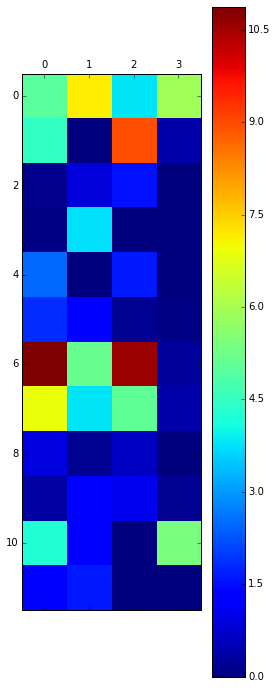

In [21]:
plt.matshow(-np.log10(pcorr_store))
plt.colorbar()

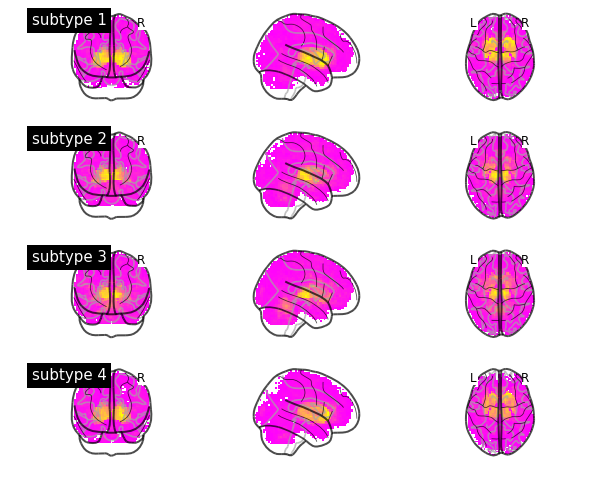

In [22]:
# Get the subtype
visu_subtype(subtype_store[0,...], mask_path, threshold=0.3, figsz=(10,8))

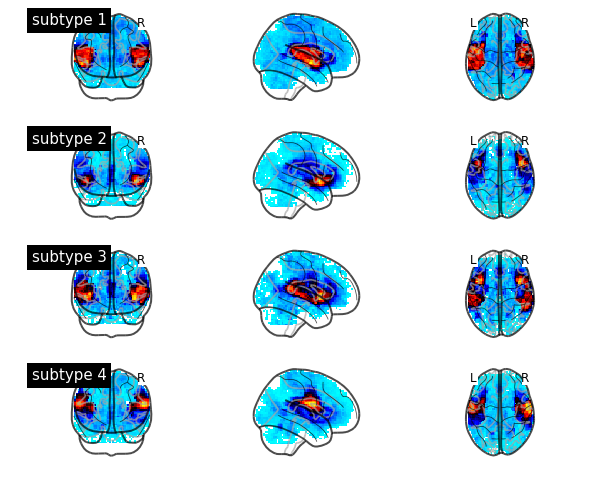

In [23]:
visu_subtype(subtype_store[1,...], mask_path, threshold=0.3, figsz=(10,8), colm=hotcold)

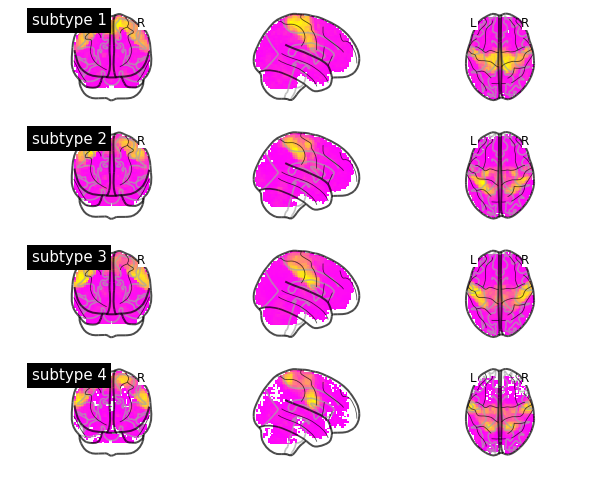

In [24]:
visu_subtype(subtype_store[6,...], mask_path, threshold=0.3, figsz=(10,8))

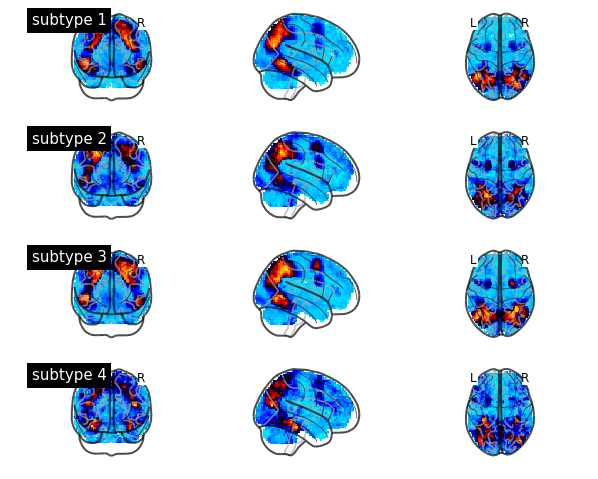

In [25]:
visu_subtype(subtype_store[8,...], mask_path, threshold=0.3, figsz=(10,8), colm=hotcold)